In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DConditionModel, AutoencoderKL
from peft import LoraConfig, get_peft_model, PeftModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
import numpy as np

# Enable cuDNN optimization for faster training
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

# Ensure PyTorch uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Free GPU memory
torch.cuda.empty_cache()
gc.collect()

Using device: cuda


0

In [2]:


# Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, parquet_file):
        self.data = pd.read_parquet(parquet_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]["image_path"]
        image_tensor = torch.load(image_path).float()  # No manual normalization
        text_embedding = torch.tensor(self.data.iloc[idx]["combined_embedding"], dtype=torch.float32)
        return image_tensor, text_embedding

# Load Dataset
parquet_file = "../data/processed_emoji_dataset.parquet"
dataset = EmojiDataset(parquet_file)
batch_size = 32  
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:


# Load Stable Diffusion 2 Base Model
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-base", subfolder="vae").to(device, dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2-base", subfolder="unet").to(device, dtype=torch.float16)

# Apply LoRA to UNet
lora_config = LoraConfig(
    r=1,  # LoRA rank
    lora_alpha=8,  # Scaling factor
    target_modules=["to_q", "to_k", "to_v", "proj_out", "proj_in"],  
    lora_dropout=0.1,  # Dropout for regularization
    bias="none"
)

unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Enable memory optimization
unet.enable_gradient_checkpointing()

class EmbeddingProjector(nn.Module):
    def __init__(self, input_dim=512, output_dim=1024):  # Change output to 1280
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

embedding_projector = EmbeddingProjector().to(device, dtype=torch.float16)

# Freeze VAE
for param in vae.parameters():
    param.requires_grad = False  

# Define optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, unet.parameters()), lr=0.001)
scaler = torch.amp.GradScaler()

trainable params: 207,488 || all params: 866,118,212 || trainable%: 0.0240


In [4]:


# Training Loop
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, embeddings in progress_bar:
        images = images.to(device, dtype=torch.float16, non_blocking=True)
        embeddings = embeddings.to(device, dtype=torch.float16, non_blocking=True)
        optimizer.zero_grad()

        # Project CLIP embeddings
        with torch.no_grad():
            projected_embeddings = embedding_projector(embeddings).unsqueeze(1)
        
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample() * 0.18215
        latents = latents.to(torch.float16)

        # Generate noise
        noise = torch.randn_like(latents, dtype=torch.float16)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

        # Forward pass
        with torch.amp.autocast("cuda"):
            noise_pred = unet(latents, timesteps, encoder_hidden_states=projected_embeddings).sample
            loss = F.mse_loss(noise_pred, noise)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")


Epoch 1/30: 100%|██████████| 85/85 [01:25<00:00,  1.01s/it, loss=1.01] 


Epoch 1/30, Loss: 1.0192


Epoch 2/30: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=1.02] 


Epoch 2/30, Loss: 1.0038


Epoch 3/30: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s, loss=1.01] 


Epoch 3/30, Loss: 0.9992


Epoch 4/30: 100%|██████████| 85/85 [01:13<00:00,  1.15it/s, loss=0.993]


Epoch 4/30, Loss: 1.0045


Epoch 5/30: 100%|██████████| 85/85 [01:08<00:00,  1.23it/s, loss=1.01] 


Epoch 5/30, Loss: 1.0002


Epoch 6/30: 100%|██████████| 85/85 [01:44<00:00,  1.23s/it, loss=0.974]


Epoch 6/30, Loss: 0.9950


Epoch 7/30: 100%|██████████| 85/85 [01:47<00:00,  1.27s/it, loss=1.01] 


Epoch 7/30, Loss: 0.9963


Epoch 8/30: 100%|██████████| 85/85 [01:34<00:00,  1.11s/it, loss=1.02] 


Epoch 8/30, Loss: 0.9996


Epoch 9/30: 100%|██████████| 85/85 [01:42<00:00,  1.21s/it, loss=0.977]


Epoch 9/30, Loss: 0.9990


Epoch 10/30: 100%|██████████| 85/85 [01:43<00:00,  1.21s/it, loss=0.987]


Epoch 10/30, Loss: 0.9999


Epoch 11/30: 100%|██████████| 85/85 [01:58<00:00,  1.40s/it, loss=0.978]


Epoch 11/30, Loss: 1.0007


Epoch 12/30: 100%|██████████| 85/85 [03:26<00:00,  2.42s/it, loss=0.994]


Epoch 12/30, Loss: 0.9972


Epoch 13/30: 100%|██████████| 85/85 [02:44<00:00,  1.93s/it, loss=1.01] 


Epoch 13/30, Loss: 0.9998


Epoch 14/30: 100%|██████████| 85/85 [01:17<00:00,  1.10it/s, loss=1.01] 


Epoch 14/30, Loss: 1.0015


Epoch 15/30: 100%|██████████| 85/85 [01:30<00:00,  1.06s/it, loss=0.972]


Epoch 15/30, Loss: 0.9993


Epoch 16/30: 100%|██████████| 85/85 [02:16<00:00,  1.61s/it, loss=0.984]


Epoch 16/30, Loss: 0.9983


Epoch 17/30: 100%|██████████| 85/85 [02:28<00:00,  1.75s/it, loss=1.03] 


Epoch 17/30, Loss: 0.9990


Epoch 18/30: 100%|██████████| 85/85 [03:28<00:00,  2.46s/it, loss=1.01] 


Epoch 18/30, Loss: 1.0001


Epoch 19/30: 100%|██████████| 85/85 [03:27<00:00,  2.44s/it, loss=1.01] 


Epoch 19/30, Loss: 1.0030


Epoch 20/30: 100%|██████████| 85/85 [03:53<00:00,  2.75s/it, loss=1.02] 


Epoch 20/30, Loss: 1.0005


Epoch 21/30: 100%|██████████| 85/85 [03:07<00:00,  2.21s/it, loss=1.01] 


Epoch 21/30, Loss: 1.0013


Epoch 22/30: 100%|██████████| 85/85 [02:53<00:00,  2.04s/it, loss=0.991]


Epoch 22/30, Loss: 0.9972


Epoch 23/30: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.979]


Epoch 23/30, Loss: 0.9999


Epoch 24/30: 100%|██████████| 85/85 [01:24<00:00,  1.00it/s, loss=0.995]


Epoch 24/30, Loss: 1.0009


Epoch 25/30: 100%|██████████| 85/85 [01:28<00:00,  1.04s/it, loss=0.999]


Epoch 25/30, Loss: 1.0015


Epoch 26/30: 100%|██████████| 85/85 [02:44<00:00,  1.94s/it, loss=1.04] 


Epoch 26/30, Loss: 1.0005


Epoch 27/30: 100%|██████████| 85/85 [03:25<00:00,  2.42s/it, loss=1.02] 


Epoch 27/30, Loss: 0.9982


Epoch 28/30: 100%|██████████| 85/85 [03:11<00:00,  2.25s/it, loss=0.999]


Epoch 28/30, Loss: 1.0027


Epoch 29/30: 100%|██████████| 85/85 [03:11<00:00,  2.26s/it, loss=0.996]


Epoch 29/30, Loss: 0.9996


Epoch 30/30: 100%|██████████| 85/85 [03:16<00:00,  2.32s/it, loss=1]    

Epoch 30/30, Loss: 0.9982


In [8]:

# Save Model
torch.save({
    "unet": unet.state_dict(),
    "embedding_projector": embedding_projector.state_dict()
}, "emoji_generator.pth")
print("Model saved successfully!")

Model saved successfully!


LoRA adapters saved successfully!


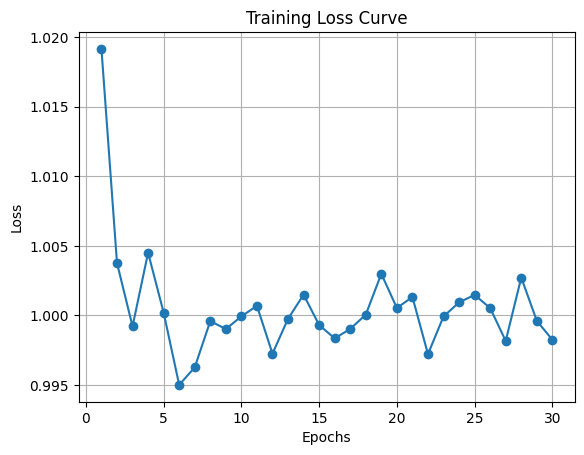

In [9]:
# Save LoRA Weights
unet.save_pretrained("lora_emoji_unet")
torch.save(embedding_projector.state_dict(), "embedding_projector.pth")
print("LoRA adapters saved successfully!")

# Plot Loss Curve
plt.plot(range(1, num_epochs + 1), losses, marker="o", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

In [10]:
# Load Model for Inference
unet = PeftModel.from_pretrained(unet, "lora_emoji_unet").to(device).to(torch.float16)
embedding_projector.load_state_dict(torch.load("embedding_projector.pth"))
unet.eval()
embedding_projector.eval()

c:\Study\College\Project\myvenv\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
c:\Study\College\Project\myvenv\Lib\site-packages\peft\peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.down_blocks.0.attentions.0.proj_in.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.proj_in.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.at

EmbeddingProjector(
  (fc): Linear(in_features=512, out_features=1024, bias=True)
)

In [11]:
# Load CLIP Model
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Text Processing
text_description = "Smiling face"
tokens = tokenizer(text_description, return_tensors="pt").to(device)
text_embedding = text_encoder(**tokens).last_hidden_state[:, 0, :]  # Use CLS token
text_embedding = text_embedding.to(torch.float16)
projected_embedding = embedding_projector(text_embedding).unsqueeze(0).to(torch.float16)

# Generate Noise
latents = torch.randn(1, 4, 64, 64, device=device, dtype=torch.float16)
timesteps = torch.tensor([500], device=device).long()

In [12]:


# Generate Emoji
with torch.no_grad():
    denoised_latents = unet(latents, timesteps, encoder_hidden_states=projected_embedding).sample

denoised_latents = denoised_latents / 0.18215

with torch.no_grad():
    decoded_image = vae.decode(denoised_latents).sample

decoded_image = (decoded_image.clamp(-1, 1) + 1) / 2
emoji_image = Image.fromarray((decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
emoji_image.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DConditionModel, AutoencoderKL
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
import numpy as np
from transformers import CLIPTokenizer, CLIPTextModel
from peft import LoraConfig, PeftModel

### Prompt(GPT 4o): Fine tunning Stable Difussion model using Lora .

In [ ]:
# Enable cuDNN optimization for faster training
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

# Ensure PyTorch uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Free GPU memory
torch.cuda.empty_cache()
gc.collect()

Using device: cuda


0

In [ ]:
# Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, parquet_file):
        self.data = pd.read_parquet(parquet_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]["image_path"]
        image_tensor = torch.load(image_path).float() / 127.5 - 1  # Normalize to [-1,1]
        text_embedding = torch.tensor(self.data.iloc[idx]["combined_embedding"], dtype=torch.float32)
        return image_tensor, text_embedding

In [ ]:
# Load Dataset
parquet_file = "../data/processed_emoji_dataset.parquet"
dataset = EmojiDataset(parquet_file)
batch_size = 32  
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load Stable Diffusion 2 Base Model (Trained on 256x256 images)
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-base", subfolder="vae").to(device, dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2-base", subfolder="unet").to(device, dtype=torch.float16)

print(unet.config) 

FrozenDict({'sample_size': 64, 'in_channels': 4, 'out_channels': 4, 'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'down_block_types': ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D'], 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'up_block_types': ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D'], 'only_cross_attention': False, 'block_out_channels': [320, 640, 1280, 1280], 'layers_per_block': 2, 'downsample_padding': 1, 'mid_block_scale_factor': 1, 'dropout': 0.0, 'act_fn': 'silu', 'norm_num_groups': 32, 'norm_eps': 1e-05, 'cross_attention_dim': 1024, 'transformer_layers_per_block': 1, 'reverse_transformer_layers_per_block': None, 'encoder_hid_dim': None, 'encoder_hid_dim_type': None, 'attention_head_dim': [5, 10, 20, 20], 'num_attention_heads': None, 'dual_cross_attention': False, 'use_linear_projection': True, 'class_embed_type': None, 'addition_embed_type': None, 'addition_time_embed_dim': 

In [ ]:

# Apply LoRA to UNet
lora_config = LoraConfig(
    r=1,  # LoRA rank
    lora_alpha=8,  # Scaling factor
    target_modules=["to_q", "to_k", "to_v", "proj_out", "proj_in"],  
    lora_dropout=0.1,  # Dropout for regularization
    bias="none"
)

unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()  # Print trainable parameters (should be very small)

trainable params: 207,488 || all params: 866,118,212 || trainable%: 0.0240


In [ ]:
# Enable memory optimization
unet.enable_gradient_checkpointing()

# Embedding Projector (CLIP 512 → UNet 768)
class EmbeddingProjector(nn.Module):
    def __init__(self, input_dim=512, output_dim=1024):  # Changed to 768
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

embedding_projector = EmbeddingProjector().to(device, dtype=torch.float16)

# Freeze VAE
for param in vae.parameters():
    param.requires_grad = False  

# Define optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, unet.parameters()), lr=0.001)
scaler = torch.amp.GradScaler()

In [ ]:
# Training Loop
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, embeddings in progress_bar:
        images = images.to(device, dtype=torch.float16, non_blocking=True)
        embeddings = embeddings.to(device, dtype=torch.float16, non_blocking=True)
        optimizer.zero_grad()

        # Project CLIP embeddings
        with torch.no_grad():
            projected_embeddings = embedding_projector(embeddings).unsqueeze(1)
        
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample() * 0.18215

        # Convert latents to bfloat16 to save memory
        latents = latents.to(torch.float16)

        # Generate noise
        noise = torch.randn_like(latents, dtype=torch.float16)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

        # Forward pass
        with torch.amp.autocast("cuda"):
            noise_pred = unet(latents, timesteps, encoder_hidden_states=projected_embeddings).sample
            loss = F.mse_loss(noise_pred, noise)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)  # Avoid NaN issues
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")


Epoch 1/5:   0%|          | 0/85 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../data/tensor_images/OpenMojiEmoji\\1f468-1f468-1f467-1f467.pt'

In [ ]:

# Save Model
torch.save({
    "unet": unet.state_dict(),
    "embedding_projector": embedding_projector.state_dict()
}, "emoji_generator.pth")
print("Model saved successfully!")

# Save LoRA Weights
unet.save_pretrained("lora_emoji_unet")
torch.save(embedding_projector.state_dict(), "embedding_projector.pth")
print("LoRA adapters saved successfully!")


In [ ]:

# Plot Loss Curve
plt.plot(range(1, num_epochs + 1), losses, marker="o", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()


In [ ]:
unet = PeftModel.from_pretrained(unet, "lora_emoji_unet").to(device).to(torch.float16)
embedding_projector.load_state_dict(torch.load("embedding_projector.pth"))
unet.eval()
embedding_projector.eval()


In [ ]:

# Assuming the necessary models are already loaded
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = text_encoder.to(device)

In [ ]:
# Define your text prompt
text_description = "Smiling face"  # This is where we specify "dog"

# Tokenize and encode the text prompt
tokens = tokenizer(text_description, return_tensors="pt").to(device)
text_embedding = text_encoder(**tokens).last_hidden_state.mean(dim=1)  # Aggregate token embeddings
text_embedding = text_embedding.to(torch.float16)  # Ensure it's float16 for compatibility with UNet

In [ ]:
# Project the embedding to match UNet’s expected format
projected_embedding = embedding_projector(text_embedding).unsqueeze(0).to(torch.float16)  # Ensure float16

# Generate noise in latent space (fixed size 96x96)
latents = torch.randn(1, 4, 96, 96).to(device).to(torch.float16)  # Ensure latents are in float16
timesteps = torch.tensor([500], device=device).long()
torch.cuda.empty_cache()
gc.collect()

# Generate noise in latent space (smaller size)
latents = torch.randn(1, 4, 64, 64, device=device, dtype=torch.float16)
timesteps = torch.tensor([500], device=device).long()

In [ ]:
# Generate Emoji
with torch.no_grad():
    denoised_latents = unet(latents, timesteps, encoder_hidden_states=projected_embedding).sample

# Move to CPU and Decode
denoised_latents = denoised_latents / 0.18215

with torch.no_grad():
    decoded_image = vae.decode(denoised_latents).sample

In [ ]:


# Post-process Image
decoded_image = (decoded_image.clamp(-1, 1) + 1) / 2
decoded_image = decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
decoded_image = (decoded_image * 255).astype(np.uint8)
emoji_image = Image.fromarray(decoded_image)

# Display the image
emoji_image.show()
